# Actor Critic with Pytorch
### Introduction
This notebook will train a policy using the actor-critic framework, where the policy is trained usign the policy gradient algorithm (Actor) while another network will learn an estimate of the value function (critic). This framework is more sample efficient than just using Policy gradients, it's a way to merge Policy and Value based methods.
One big advangage of Actor-Critic models are the sample efficiency. Now we don't need to wait for a full eposide to start learning, we can make an update at each timestep.

### Algorithm

![alt text](imgs/actor_critic.png "Game")
The main actors are:
* Critic: Estimate how good the action taken is. (Input state, output scalar value with estimative)
* Actor: Just the policy (Input state, output distribution of actions)

#### References
* https://medium.com/@henrymao/reinforcement-learning-using-asynchronous-advantage-actor-critic-704147f91686
* https://medium.freecodecamp.org/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d
* https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752
* https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2
* https://github.com/nikhilbarhate99/Actor-Critic
* http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf
* https://www.youtube.com/watch?v=O5BlozCJBSE
* https://www.youtube.com/watch?v=bRfUxQs6xIM&t=28s
* https://www.youtube.com/watch?v=lvoHnicueoE&t=4s
* http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/

### Import Libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### Initialize Environment and Hyperparameters

In [2]:
#env = gym.make('CartPole-v1')
# Uncomment for this environment (takes longer to train)
env = gym.make('LunarLander-v2')
env.seed(1)
torch.manual_seed(1)

# Hyperparameters
learning_rate = 0.01
gamma = 0.99
num_episodes=3000
render = False

print('Amount of rewards consider as win:', env.spec.reward_threshold)
print('Action space:', env.action_space.n)
print('Observation space:', env.observation_space.shape)
print('Reward range:', env.reward_range)

Amount of rewards consider as win: 200
Action space: 4
Observation space: (8,)
Reward range: (-inf, inf)


/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Define the Actor/Critic Model

In [3]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128
        
        self.affine = nn.Linear(state_space, num_hidden, bias=False)
        
        # Action and value head
        self.action_layer = nn.Linear(num_hidden, action_space, bias=False)
        self.value_layer = nn.Linear(num_hidden, 1, bias=False)
        
        self.logprobs = []
        self.state_values = []
        self.rewards = []
        # Store sum of rewards from each episode
        self.reward_history = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))
        
        state_value = self.value_layer(state)
        
        # Sample policy action space
        action_probs = F.softmax(self.action_layer(state), dim=-1)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        
        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        
        return action.item()
    
    def calculateLoss(self, gamma=0.99):
        
        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)
        
        # Append total rewards on the episode
        self.reward_history.append(np.sum(self.rewards))
                
        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())
        
        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            #print('value:', torch.squeeze(value, 0))
            #print('reward:', reward)
            #assert(false)
            value_loss = F.smooth_l1_loss(torch.squeeze(value, 0), reward.float())
            loss += (action_loss + value_loss)
        return loss
    
    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

### Initialize Network and Optimizer

In [4]:
policy = ActorCritic()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Train on the Environment

In [5]:
running_reward = 0
for episode in range(num_episodes):
    state = env.reset()
    
    # Run a full eposide
    for time in range(1000):
        action = policy(state)
        state, reward, done, _ = env.step(action)
        policy.rewards.append(reward)
        running_reward += reward
        if done:
            break

    # Updating the policy :
    optimizer.zero_grad()
    loss = policy.calculateLoss(gamma)
    loss.backward()
    optimizer.step()        
    policy.clearMemory()

    if (running_reward/time) > env.spec.reward_threshold:
        print("########## Solved! ##########")
        break

    if episode % 50 == 0:
        rewards_per_time = running_reward/time
        print('Episode {}\tlength: {}\tmean reward: {}'.format(
            episode, time, rewards_per_time))
        running_reward = 0

Episode 0	length: 100	reward: -1.1930579914161905	run_reward: -1.1930579914161905
Episode 50	length: 93	reward: -198.21811796085885	run_reward: -198.21811796085885
Episode 100	length: 102	reward: -75.82101314361773	run_reward: -75.82101314361773
Episode 150	length: 71	reward: -74.0777645937939	run_reward: -74.0777645937939
Episode 200	length: 91	reward: -43.24332036505517	run_reward: -43.24332036505517
Episode 250	length: 171	reward: -10.806447680769157	run_reward: -10.806447680769157
Episode 300	length: 272	reward: -3.9034284002092203	run_reward: -3.9034284002092203
Episode 350	length: 195	reward: -7.261331415652243	run_reward: -7.261331415652243
Episode 400	length: 676	reward: 1.8800774126644595	run_reward: 1.8800774126644595
Episode 450	length: 282	reward: -33.23401338312611	run_reward: -33.23401338312611
Episode 500	length: 196	reward: -69.38725385621258	run_reward: -69.38725385621258
Episode 550	length: 999	reward: -1.8933919358282751	run_reward: -1.8933919358282751


KeyboardInterrupt: 

### Plot Training information

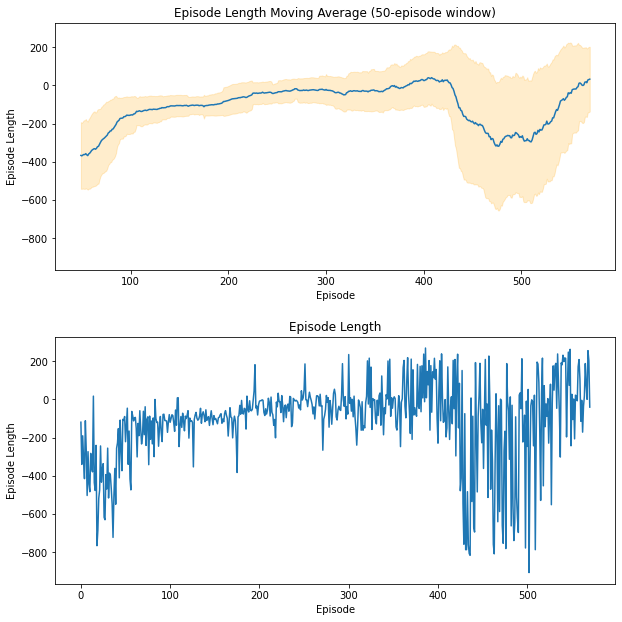

In [6]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

### Test the Trained Policy

In [7]:
def play_on_environment(env, model, t_max):
    state = env.reset()
    for t in range(t_max):
        action = policy(state)
        state, reward, done, _ = env.step(action)
        # Game finished
        if done:
            break
            
env = gym.wrappers.RecordVideo(gym.make("LunarLander-v2"), 'video')
play_on_environment(env, policy, t_max=5000)
env.close()

/Users/leonardoaraujo/anaconda3/lib/python3.8/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/leonardoaraujo/work/more_rl/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
